In [1]:
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import yfinance as yf
import time
import warnings
import os
warnings.filterwarnings('ignore')
url = 'http://www.cgs.or.kr/business/esg_tab04.jsp?pg=1&pp=10&skey=&svalue=&sfyear=2021&styear=2021&sgtype=&sgrade=#ui_contents'

### 셀레니움과 beautifulSoup으로 기업명과 기업코드 가져오기

In [66]:
def crawling_data(url):
    driver = webdriver.Chrome('chromedriver/chromedriver.exe')
    driver.get(url)

    next_button = '//*[@id="ui_contents"]/div[2]/div[4]/button[2]'
    btn_cnt = 0
    company_ticker_list = []

    while btn_cnt < 10:
        for page in range(2, 12):
            html = driver.page_source
            soup = bs(html, 'html.parser')

            for code in range(1, 11):
                name = soup.select(f'#ui_contents > div.rating-wrap > div.business_board > table > tbody > tr:nth-child({i}) > td:nth-child(2)')[0].text
                ticker = soup.select(f'#ui_contents > div.rating-wrap > div.business_board > table > tbody > tr:nth-child({code}) > td:nth-child(3)')[0].text
                company_ticker_list.append({name:ticker})
                time.sleep(1)

            page_button = f'//*[@id="ui_contents"]/div[2]/div[4]/span/a[{page}]'

            if page == 11:
                driver.find_element_by_xpath(next_button).click()
                btn_cnt+=1
                continue
            driver.find_element_by_xpath(page_button).click()
            time.sleep(1)

    df = pd.DataFrame(company_ticker_list)
    return df

In [54]:
ticker_df = crawling_data(url)
ticker_df.head()

,회사명,ticker
0,AJ네트웍스,095570
1,AK홀딩스,006840
2,AP시스템,265520
3,BGF,027410
4,BGF리테일,282330


In [57]:
ticker_df.to_csv('./data/기업코드.csv',index=False)

In [62]:
# 잘 저장되이있는 지 확인
ticker_df = pd.read_csv('./data/기업코드.csv', dtype=object)
ticker_df.head()

,회사명,ticker
0,AJ네트웍스,095570
1,AK홀딩스,006840
2,AP시스템,265520
3,BGF,027410
4,BGF리테일,282330


In [63]:
ticker_df.tail()

,회사명,ticker
995,휠라홀딩스,081660
996,휴니드테크놀러지스,005870
997,휴비스,079980
998,휴스틸,005010
999,휴온스,243070


### openApi를 활용해 pdf 파일을 csv파일로 변환

In [75]:
# !pip install git+https://github.com/pdftables/python-pdftables-api.git

  Running command git clone --filter=blob:none --quiet https://github.com/pdftables/python-pdftables-api.git 'C:\Users\tjgml\AppData\Local\Temp\pip-req-build-s3m2innq'



  Cloning https://github.com/pdftables/python-pdftables-api.git to c:\users\tjgml\appdata\local\temp\pip-req-build-s3m2innq
  Resolved https://github.com/pdftables/python-pdftables-api.git to commit a2d329a346197c4dcfc6d1b63b02a89dc87481e6
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pdftables-api: filename=pdftables_api-1.1.0-py3-none-any.whl size=5916 sha256=dfda3ab0066655d43faaa877ef71912121fa242d59b3bd395649a8549c5d3db6
  Stored in directory: C:\Users\tjgml\AppData\Local\Temp\pip-ephem-wheel-cache-8xa3o6s0\wheels\08\f9\61\03de7463e2d9a990f0ee3865faf7286ad320d0a0095bb99cc9
Successfully built pdftables-api


In [156]:
# Import Module
import pdftables_api

# API KEY VERIFICATION
key = 'o2avkfspsnqq'

# csv로 변환
def trans_csv(key, pdf_path, csv_path):
    conversion = pdftables_api.Client(key)
    conversion.csv(pdf_path, csv_path)

file_list = os.listdir('./data/각종목ESG등급(11~18)/')
krx_df_list = []
for filename in file_list:
    tmp_df = pd.read_csv(f'./data/각종목ESG등급(11~18)/{filename}')
    krx_df_list.append(tmp_df)

In [5]:
krx_df_list[0].columns

Index(['종목명', '통합등급', '환경', '사회', '지배구조', '평가연도'], dtype='object')

## yfinance를 이용해 각 회사 주식 데이터 가져오기

In [9]:
def get_jusik_data(df, sdate, edate):
    jusik_list = []

    for ii in df.index:
        cname = df.loc[ii, '기업명']
        code = df.loc[ii, '기업코드'] + str('.KS')
        print(cname, code)
        if len(code) != 9:
            print('잘못된 코드입니다.')
            continue
        df_aapi = yf.download(code, start=sdate, end=edate, progress=False)
        jusik_list.append({cname : df_aapi})

    return jusik_list

In [23]:
import numpy as np
company_code_df = pd.read_csv('data/기업명_기업코드.csv', dtype=object)
company_code_df.drop(columns=['Unnamed: 0'], inplace=True)
company_jusik_list = get_jusik_data(company_code_df, '2010-01-01', '2022-03-31')

AJ네트웍스 095570.KS
AK홀딩스 006840.KS
BGF 027410.KS
BNK금융지주 138930.KS
BYC 001460.KS
CJ 001040.KS
CJ CGV 079160.KS
CJ대한통운 000120.KS
CJ씨푸드 011150.KS
CJ제일제당 097950.KS
CS홀딩스 000590.KS
DB 012030.KS
DB금융투자 016610.KS
DB손해보험 005830.KS
DB하이텍 000990.KS
DGB금융지주 139130.KS
DRB동일 004840.KS
DSR 155660.KS
DSR제강 069730.KS
E1 017940.KS
F&F 007700.KS
GKL 114090.KS
GS 078930.KS
GS건설 006360.KS
GS글로벌 001250.KS
GS리테일 007070.KS
HDC 012630.KS
HDC현대EP 089470.KS
HSD엔진 082740.KS
JB금융지주 175330.KS
JW생명과학 234080.KS
JW중외제약 001060.KS
JW홀딩스 096760.KS
KB금융 105560.KS
KC그린홀딩스 009440.KS
KC코트렐 119650.KS
KEC 092220.KS
KG케미칼 001390.KS
KISCO홀딩스 001940.KS
KPX케미칼 025000.KS
KPX홀딩스 092230.KS
KR모터스 000040.KS
KSS해운 044450.KS
KTcs 058850.KS
LF 093050.KS
LG 003550.KS
LG디스플레이 034220.KS
LG생활건강 051900.KS
LG유플러스 032640.KS
LG이노텍 011070.KS
LG전자 066570.KS
LG화학 051910.KS
LIG넥스원 079550.KS
LS 006260.KS
LS네트웍스 000680.KS
LS전선아시아 229640.KS
MH에탄올 023150.KS
NAVER 035420.KS
NH투자증권 005940.KS
NICE 034310.KS
NI스틸 008260.KS
OCI 010060.KS
S-Oil 010950.KS
SBS 0

In [24]:
# 2011년 이후부터 상장된 회사 리스트
company_list = []

for i in company_code_df.index:
    name = company_code_df.loc[i, '기업명']
    tmp_df2 = company_jusik_list[i].get(name)
    year = int(str(tmp_df2.index[0])[:4])
    if year > 2011:
        print(year, name)
        company_list.append(name)

len(company_list)

2015 AJ네트웍스
2014 BGF
2013 DSR
2016 JW생명과학
2015 LIG넥스원
2016 LS전선아시아
2015 SK디앤디
2015 경보제약
2015 금호에이치티
2013 동아에스티
2012 동일고무벨트
2015 동일제강
2016 두산밥캣
2016 두올
2015 디와이파워
2014 만도
2014 미래에셋생명
2012 사조씨푸드
2014 삼성물산
2016 삼성바이오로직스
2014 삼성에스디에스
2016 샘표식품
2014 서연이화
2018 세아제강
2015 세진중공업
2013 신송홀딩스
2014 씨에스윈드
2013 아세아시멘트
2016 용평리조트
2019 우리금융지주
2015 이노션
2016 일동제약
2015 잇츠한불
2016 제이에스코퍼레이션
2014 제주항공
2013 종근당
2012 지엠비코리아
2014 코스맥스
2014 쿠쿠홀딩스
2015 토니모리
2016 한국자산신탁
2012 한국콜마
2015 한솔제지
2018 한일시멘트
2013 한진칼
2016 해성디에스
2016 해태제과식품
2016 핸즈코퍼레이션
2013 현대로템
2015 현대코퍼레이션홀딩스
2016 화승엔터프라이즈
2014 화인베스틸


52

In [26]:
## 뽑은 주식 데이터 회사별로 저장
for i in company_code_df.index:
    name = company_code_df.loc[i, '기업명']
    jusik_df = company_jusik_list[i].get(name)
    jusik_df.to_csv(f'./data/회사별주식데이터/{name}.csv')

#### yfinance모듈로 KOSPI지수 구하기

In [55]:
yf.pdr_override()
kospi = pdr.get_data_yahoo('^KS11', '2011-01-01')

df_kospi = pd.DataFrame({'KOSPI':kospi['Close']})
df_kospi.head()

[*********************100%***********************]  1 of 1 completed


,KOSPI
Date,
2011-01-03,2070.080078
2011-01-04,2085.139893
2011-01-05,2082.550049
2011-01-06,2077.610107
2011-01-07,2086.199951


In [56]:
df_kospi.tail()

,KOSPI
Date,
2022-04-28,2667.489990
2022-04-29,2695.050049
2022-05-02,2687.449951
2022-05-03,2680.459961
2022-05-04,2685.149902


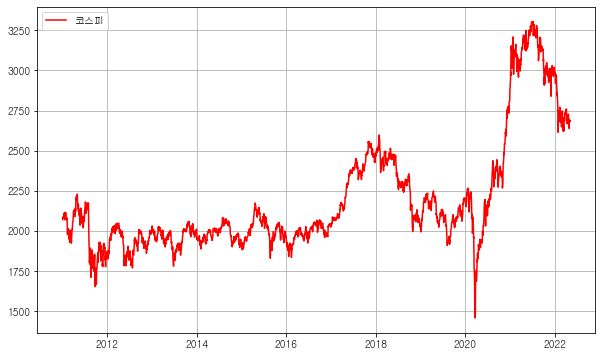

In [61]:
#한글폰트 적용
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

plt.figure(figsize=(10,6))
plt.plot(kospi.index, kospi.Close, 'r', label='코스피')
plt.grid(True)
plt.legend(loc='best')
plt.savefig('./data/코스피시각화.jpg')
plt.show()

In [60]:
df_kospi.to_csv('./data/코스피지수.csv')

In [74]:
df_jamu = pd.read_csv('./data/전체.csv')
df_jamu.drop(columns=['Unnamed: 0'], inplace=True)
df_jamu.head()

,고유번호,기업명,자산총계,부채총계,자본총계,당기순이익,연도
0,102113,경인양행,579492465098,327622550348,251869914750,27210074941,2021
1,103592,광동제약,883845298043,356600480140,527244817903,25540744737,2021
2,104519,국보,102314951997,70471633267,31843318730,-17669052258,2021
3,104786,미래아이앤지,99668333058,28587955823,71080377235,-18081302852,2021
4,104999,윌비스,294073485577,183381461941,110692023636,-8532095509,2021


In [76]:
df_jamu.tail()

,고유번호,기업명,자산총계,부채총계,자본총계,당기순이익,연도
5987,956930,동아에스티,1063538923196,509765483221,553773439975,48573315513,2015
5988,983040,한진칼,2315048938843,846537512824,1468511426019,-193723899362,2015
5989,990165,아세아시멘트,809317420218,182684468071,626632952147,44346134836,2015
5990,1067516,골프존,178132252912,69278343432,108853909480,36533154720,2015
5991,120562,롯데지주,4228827416044,1431503351896,2797324064148,36831003453,2015


In [75]:
df_siga = pd.read_csv('./data/시가총액.csv')
df_siga.drop(columns=['Unnamed: 0'], inplace=True)
df_siga.head()

,종목코드,종목명,2011_1분기,2011_2분기,2011_3분기,2011_4분기,2012_1분기,2012_2분기,2012_3분기,2012_4분기,...,2019_4분기,2020_1분기,2020_2분기,2020_3분기,2020_4분기,2021_1분기,2021_2분기,2021_3분기,2021_4분기,2022_1분기
0,069110,3H,4.421505e+10,4.780265e+10,4.631109e+10,3.723739e+10,3.341377e+10,2.787366e+10,3.579909e+10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,060310,3S,1.500834e+11,1.480114e+11,3.503794e+11,9.867575e+11,8.105189e+11,6.818519e+11,4.246380e+11,2.784926e+11,...,1.233659e+11,7.758085e+10,1.125983e+11,9.734207e+10,9.983493e+10,1.094778e+11,1.452264e+11,1.782295e+11,1.518773e+11,1.518201e+11
2,900010,3노드디지탈,9.693474e+10,6.403669e+10,6.025486e+10,5.531356e+10,6.666784e+10,4.846599e+10,5.162168e+10,5.260622e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,038120,AD모터스,4.673474e+10,6.283227e+10,5.068938e+10,3.961572e+10,2.506364e+10,2.417696e+10,1.974917e+10,6.412671e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,013340,AJS,7.526157e+10,3.904602e+10,4.085304e+10,4.158156e+10,4.818040e+10,3.632788e+10,3.888645e+10,3.414454e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
